Задание 1. Загрузите текст из произведений Ницше ('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt').
Выведете следующее:
А) длину всего корпуса;
Б) количество предложений;
В) сколько всего символов используется?

In [ ]:
import requests
import nltk
nltk.download('punkt')
# Загрузка текста из файла
url = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
response = requests.get(url)
text = response.text

# Длина всего корпуса (в символах)
corpus_length = len(text)

# Количество предложений
sentences = nltk.sent_tokenize(text)
num_sentences = len(sentences)

# Сколько всего символов используется
unique_chars = set(text)
num_unique_chars = len(unique_chars)

# Вывод результатов
print(f'А) Длина всего корпуса: {corpus_length} символов')
print(f'Б) Количество предложений: {num_sentences}')
print(f'В) Количество уникальных символов: {num_unique_chars}')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


А) Длина всего корпуса: 600901 символов
Б) Количество предложений: 3163
В) Количество уникальных символов: 85


Задание 2. Сократите текст наполовину избыточными последовательностями символов maxlen

In [ ]:
import numpy as np

# Определение maxlen
maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

# Определение уникальных символов
chars = sorted(list(set(text)))
char_indices = dict((char, chars.index(char)) for char in chars)

# Вывод информации
print('nb sequences:', len(sentences))
print('Vectorization...')

nb sequences: 200294
Vectorization...


Задание 3. Создайте модель LSTM для генерации текста
А) Напишите вспомогательную функцию для выборки индекса из массива вероятностей
Б) Напишите функцию, которая будет вызываться в конце каждой эпохи и печатать сгенерированный текст
В) Запустите модель на обучение
Имейте ввиду, что требуется не менее 20 эпох, прежде чем сгенерированный текст начнет звучать связно. Рекомендуется запускать этот скрипт на графическом процессоре, так как рекуррентные сети требуют довольно больших вычислительных затрат.
Г) Проверьте работу модели в онлайн режиме.
Для примера смотрите файл lstm_генерация.ipynb

In [ ]:
from keras.callbacks import LambdaCallback
import sys

# Преобразование тренировочных данных в форму, пригодную для обучения модели
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# Создание модели LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Вспомогательная функция для выборки индекса из массива вероятностей
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Функция для генерации текста в конце каждой эпохи
def on_epoch_end(epoch, _):
    print()
    print('----- Генерация текста после эпохи: %d' % epoch)

    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('----- Начальная строка: "' + generated_text + '"')

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('----- Температура:', temperature)
        sys.stdout.write(generated_text)

        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

# Обучение модели
model.fit(x, y, batch_size=128, epochs=20, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])


Epoch 1/20
1564/1565 [============================>.] - ETA: 0s - loss: 2.6586
----- Генерация текста после эпохи: 0
----- Начальная строка: " who is affected wit"
----- Температура: 0.2
 who is affected wit of this the sere the the the sore the the the the the the the the the the the the the the sere the the the the the the sere the sere the the the the the the the the the the the the the the ar the sere the the the the the the the core the the mand and and of the the the the the the the sere the the as and the sere the the sere and and and the sere the ssere the sere the the the the sore the the th
----- Температура: 0.5
 the sore the the the bererere the the the dime it an the thal pore te the prererins for the seritis an the ther son the wind calle do
the seress ind the sise the and the phere the the the whal wor dere tis win soret an serine-s cor and the nas and an guer, cor ande te thas in the whe th tha sare pure of an the the the the the the the socast an the whes ven in and sa

Задание 4. Создайте самостоятельно генерацию текста для РУССКОЯЗЫЧНОГО НАБОРА глав Wikibooks.
Полный текст Wikibooks содержит более 270000 глав на 12 языках https://www.kaggle.com/datasets/dhruvildave/wikibooks-dataset/data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import pandas as pd
import sqlite3

# Распаковка архива
with zipfile.ZipFile('/content/drive/MyDrive/datasets/wikibooks.sqlite.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/datasets/')

# Подключение к SQLite и чтение данных
db_path = '/content/drive/MyDrive/datasets/wikibooks.sqlite'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# SQL-запрос для извлечения данных
query = 'SELECT * FROM ru'
cursor.execute(query)

# Получение результатов запроса в виде DataFrame
df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Закрытие соединения
conn.close()

# Вывод первых нескольких строк DataFrame
print(df.head())


In [ ]:
csv_path = '/content/drive/MyDrive/datasets/wikibooks_ru.csv'
df.to_csv(csv_path, index=False)

In [ ]:
csv_path = '/content/drive/MyDrive/datasets/wikibooks_ru.csv'
data = pd.read_csv(csv_path)

In [ ]:
data

In [ ]:
data['body_text	'][4]

In [ ]:
import re

In [ ]:
def text_cleaning(x):

    text = re.sub('\s+\n+', ' ', str(x))
    text = re.sub('[^a-zA-Zа-яА-Я0-9\.]', ' ', text)
    text = text.split()

    text = [word for word in text]
    text = ' '.join(text)
    text = 'startseq '+text+' endseq'

    return text

In [ ]:
data['text'] = data['body_text'].map(text_cleaning)

In [ ]:
data['text'][4]

'startseq Пенная фея Джин Old Tom 60 г Абсент 15 г Свежевыжатый лимонный сок 15 г Яичный белок сырой 1 шт Горький биттер любой несколько капель достаточно черыр х Влейте в шейкер джин лимонный сок абсент и яичный белок. Энергично встряхивайте не менее 30 секунд. Добавьте в шейкер л д на 2 3 и снова встряхивайте чтобы образовалась пена. Дважды процедите коктейль через ситечко в охлажденный коктейльный бокал. Дайте пене подняться а потом аккуратно влейте несколько капель биттера. источник https xn b1agapphj9gwb.xn p1ai koktejli s absentom 2 endseq'

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import Sequence
from keras.utils import to_categorical

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import Sequence
from keras.utils import to_categorical

In [ ]:
train = data.iloc[:6000, :]
val = data.iloc[6000:7000, :].reset_index(drop=True)
test = data.iloc[7000:, :].reset_index(drop=True)

In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'].tolist())
max_length = max(len(caption.split()) for caption in train['text'].tolist())

In [ ]:
df_vocab = pd.DataFrame(list(tokenizer.word_counts.items()), columns=['word','count'])
df_vocab.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
df_vocab = df_vocab[50:]
df_vocab.head(50)

,word,count
50,так,6658
51,м,6620
52,также,6596
53,все,6558
54,их,6483
55,y,6437
56,f,6298
57,startseq,6000
58,endseq,6000
59,только,5972


In [ ]:
from wordcloud import WordCloud

In [ ]:
import matplotlib.pyplot as plt

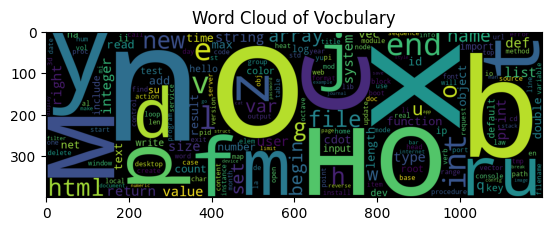

In [ ]:
words = ""
words += " ".join(df_vocab['word'].tolist())+" "
wordcloud = WordCloud(width = 1200, height = 400,
                background_color ='black',
                min_font_size = 10).generate(words)

plt.imshow(wordcloud)
plt.title('Word Cloud of Vocbulary')
plt.show()

In [ ]:
df_vocab.describe()

,count
count,242844.000000
mean,15.772331
std,114.290791
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,6658.000000


In [ ]:
df_vocab[df_vocab['count']>=50]

,word,count
50,так,6658
51,м,6620
52,также,6596
53,все,6558
54,их,6483
...,...,...
11489,промежуток,50
11490,отрицательная,50
11491,преобразуется,50
11492,флоры,50


In [ ]:
vocab_size = len(df_vocab[df_vocab['count']>=50])
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'].tolist())

In [ ]:
data['length'] = data['text'].map(lambda x: len(x.split(' ')))

In [ ]:
max_length = 50
print(train.loc[0, 'text'])
print(tokenizer.texts_to_sequences([train.loc[0, 'text']])[0])

startseq Рабочая станция Сервер Персональный компьютер. endseq
[59, 3439, 8692, 1635, 1, 2079, 60]


In [ ]:
seq = train.loc[0, 'text'].split()
X, y = [], []
for i in range(1,len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    X.append(' '.join(in_seq))
    y.append(out_seq)

example = pd.DataFrame(columns=['input','output'])
example['input'] = X
example['output'] = y
example

,input,output
0,startseq,Рабочая
1,startseq Рабочая,станция
2,startseq Рабочая станция,Сервер
3,startseq Рабочая станция Сервер,Персональный
4,startseq Рабочая станция Сервер Персональный,компьютер.
5,startseq Рабочая станция Сервер Персональный к...,endseq


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, batch_size, tokenizer, vocab_size, max_length, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y = self.__get_data(batch)
        return X, y

    def __get_data(self,batch):

        X, y = list(), list()
        captions = batch.loc[:, self.X_col].tolist()
        for caption in captions:
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            max_len = self.max_length if len(seq) > self.max_length else len(seq)
            for i in range(1,max_len):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X.append(in_seq)
                y.append(out_seq)

        X, y = np.array(X), np.array(y)

        return X, y

In [ ]:
train_gen = CustomDataGenerator(train, 'text', 16, tokenizer, vocab_size, max_length)
val_gen = CustomDataGenerator(val, 'text', 16, tokenizer, vocab_size, max_length)
test_gen = CustomDataGenerator(test, 'text', 16, tokenizer, vocab_size, max_length)

In [ ]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional, Dense, Input

In [ ]:
input_layer = Input(shape=(50,))
x = Embedding(vocab_size, 64)(input_layer)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128))(x)
output_layer = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input_layer], outputs=output_layer)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam())

In [ ]:
model_2 = Sequential()
model_2.add(Input(shape=(50,)))
model_2.add(Embedding(vocab_size, 64))
model_2.add(Bidirectional(LSTM(128)))
model_2.add(Dense(vocab_size, activation='softmax'))
model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

In [ ]:
model_2.fit(train_gen, validation_data=val_gen, epochs=50)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

es = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr * tf.math.exp(-0.1*epoch)


lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[checkpoint, es, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
375/375 [==============================] - ETA: 0s - loss: 6.3003
Epoch 1: val_loss did not improve from 4.17973
375/375 [==============================] - 67s 159ms/step - loss: 6.3003 - val_loss: 5.8019 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/25
375/375 [==============================] - ETA: 0s - loss: 5.6386
Epoch 2: val_loss did not improve from 4.17973
375/375 [==============================] - 53s 142ms/step - loss: 5.6386 - val_loss: 5.4398 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/25
375/375 [==============================] - ETA: 0s - loss: 5.2510
Epoch 3: val_loss did not improve from 4.17973
375/375 [==============================] - 52s 140ms/step - loss: 5.2510 - val_loss: 5.1241 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.00100000004749

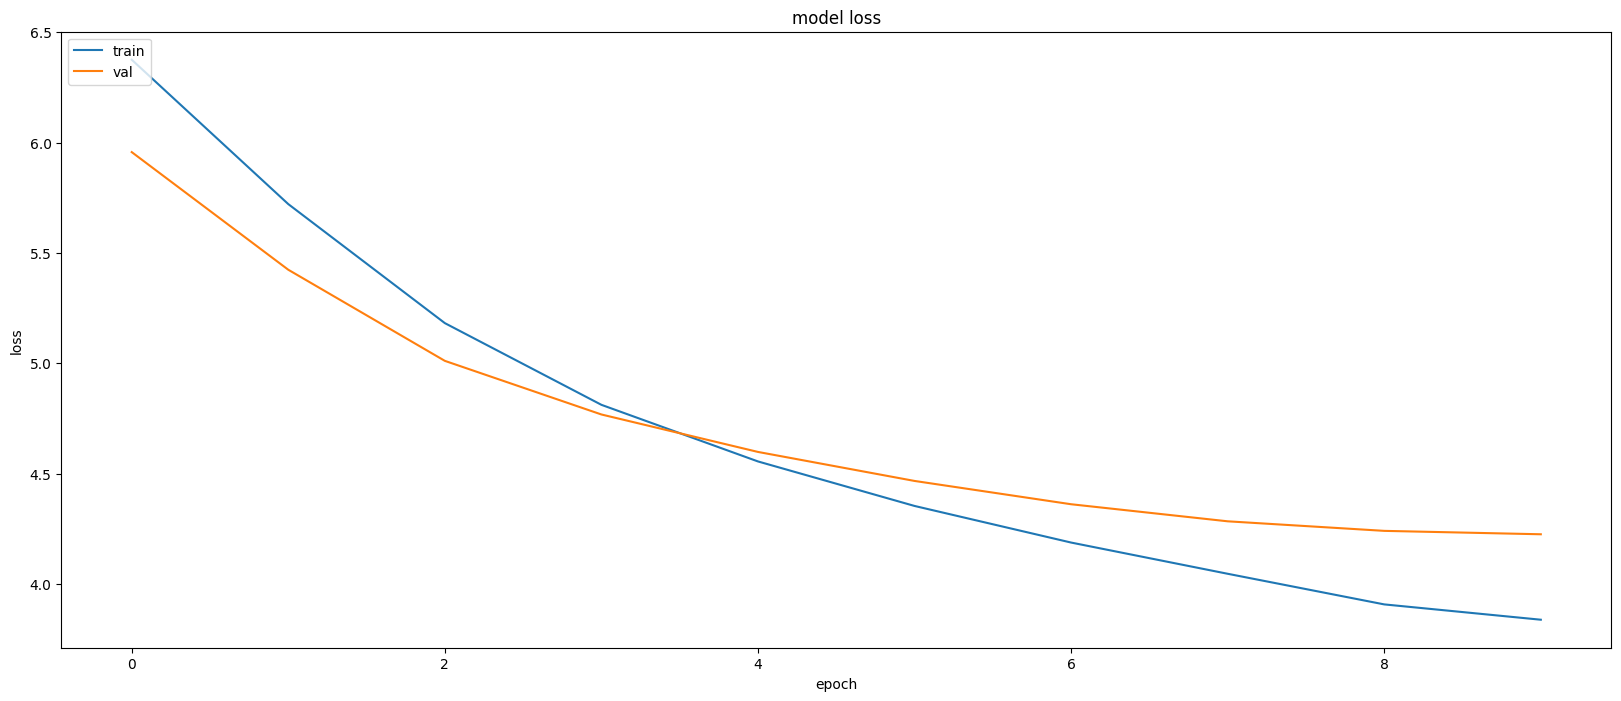

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_sentence(text, model, tokenizer, max_length):

    in_text = "startseq " + text
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict(sequence, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
def beam_search_predictions(text, beam_index = 3):
    in_text = "startseq " + text
    start = tokenizer.texts_to_sequences([in_text])[0]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length)
            preds = model.predict(par_caps, verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [idx_to_word(i, tokenizer) for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
sentences = ["рецепт коктейля включает в себя",
             "old fashion",
             "для улучшения компьютера",
             "я рекомендую",
             "весьма полезная вещь"]

for sentence in sentences:
    print("Greedy Search: ", predict_sentence(sentence, model, tokenizer, 50))
    print("Beam Search: ", beam_search_predictions(sentence))
    print("\n")

Greedy Search:  startseq рецепт коктейля включает в себя <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
Beam Search:  рецепт коктейля включает в себя английское название <OOV> <OOV> 1 один из рецептов править <OOV> 1 один из рецептов править <OOV> <OOV> 1 один из рецептов править <OOV> 1 один из рецептов править <OOV> 1 один из рецептов править <OOV> 1 один из рецептов править <OOV> 1 один из


Greedy Search:  startseq old fashion <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
Beam Search:

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model_name = "gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_name )

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [ ]:
input_text = "i am really impressed"
max_length = 128
input_ids = tokenizer(input_text, return_tensors='pt')

In [ ]:
input_ids

{'input_ids': tensor([[   72,   716,  1107, 12617]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
input_ids = input_ids['input_ids'].to(device)

In [ ]:
output = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
tokenizer.decode(output[0])

'i am really impressed with the quality of the product and the customer service.\n\nRated 5 out of 5 by Anonymous from Great product! I have been using this product for over a year now and I have never had a problem with it. I have been using this product for over a year now and I have never had a problem with it. I have been using this product for over a year now and I have never had a problem with it. I have been using this product for over a year now and I have never had a problem with it. I have been using this product for over a year now and I have never had'

In [ ]:
output = model.generate(input_ids, max_length=max_length, num_beams=5,
                        do_sample=False, no_repeat_ngram_size=2)
tokenizer.decode(output[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'i am really impressed with the quality of the product and the customer service.\n\nRated 5 out of 5 by Anonymous from Great product! I have been using this product for over a year now and I am very pleased with it. It is very easy to use and works great. I would recommend it to anyone who is looking for a product that will last a long time.<|endoftext|>'

In [ ]:
def text_generate(text):
    input_text = text
    max_length = 128
    input_ids = tokenizer(input_text, return_tensors='pt')
    input_ids = input_ids['input_ids'].to(device)
    output = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)
    return tokenizer.decode(output[0])

In [ ]:
print(text_generate('recipe of old fashion contains whiskey'))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


recipe of old fashion contains whiskey, rum, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brandy, brand
